In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
111530,54a718b55ee60689,Quite convincing. I'm surprised I didn't see t...,0,0,0,0,0,0
154527,af1e693699a5b123,"""\n\nWhat?\n""""People who criticize Wikipedia a...",0,0,0,0,0,0
151777,82ae8c042ea1dee1,I didn't want it to be read at the time. I did...,0,0,0,0,0,0


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]




continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [7]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [8]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [9]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


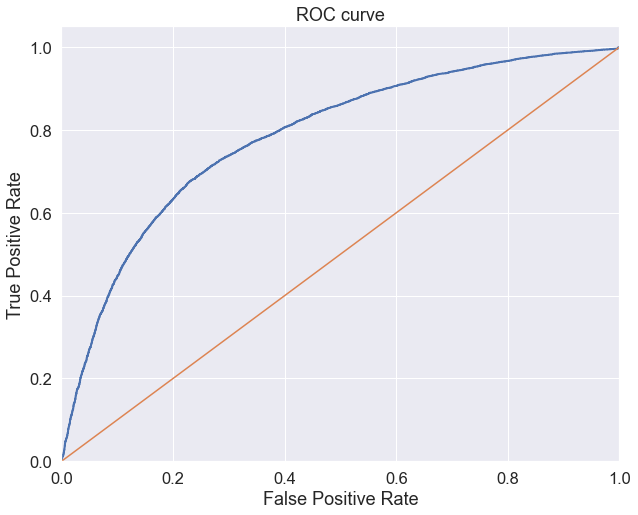

In [10]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [11]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230663


Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


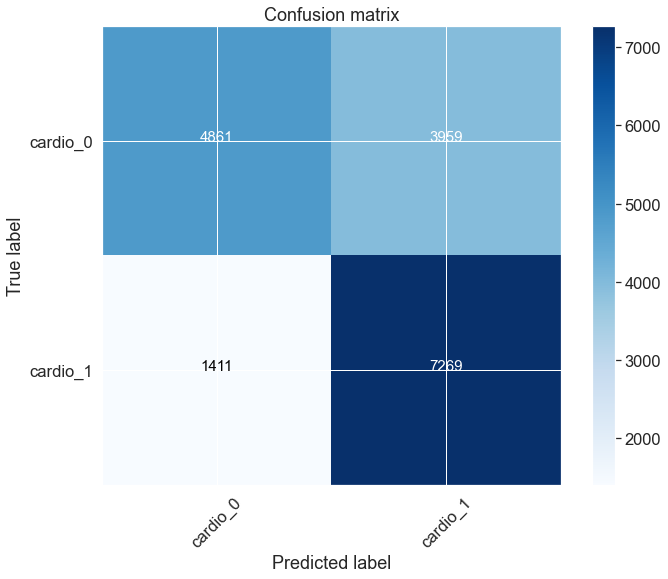

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

Average precision-recall score: 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

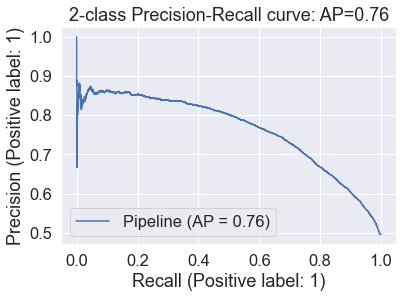

In [14]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [15]:
logreg_score = {"LogisticRegression":pd.Series([thresholds[ix],
                                                fscore[ix],
                                                precision[ix],
                                                recall[ix],
                                                roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]),
                                                log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1]),
                                                TPR,
                                                FPR,
                                                TNR],                                                
                                                index=['Threshold',
                                                       'F-Score',
                                                       'Precision',
                                                       'Recall',
                                                       'ROC_AUC',
                                                       'LOG_LOSS',
                                                       'TPR',
                                                       'FPR',
                                                       'TNR'])}

df_score = pd.DataFrame(logreg_score)
df_score

,LogisticRegression
Threshold,0.386937
F-Score,0.730323
Precision,0.647431
Recall,0.837558
ROC_AUC,0.784035
LOG_LOSS,0.577960
TPR,0.837442
FPR,0.448866
TNR,0.551134


### Домашнее задание

#### 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
##### 2. при обучении моделей обязательно использовать кроссвалидацию

##### Градиентный бустинг

In [16]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7971946542696801+-0.0069185562168582624


In [17]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.358156, F-Score=0.739, Precision=0.679, Recall=0.810


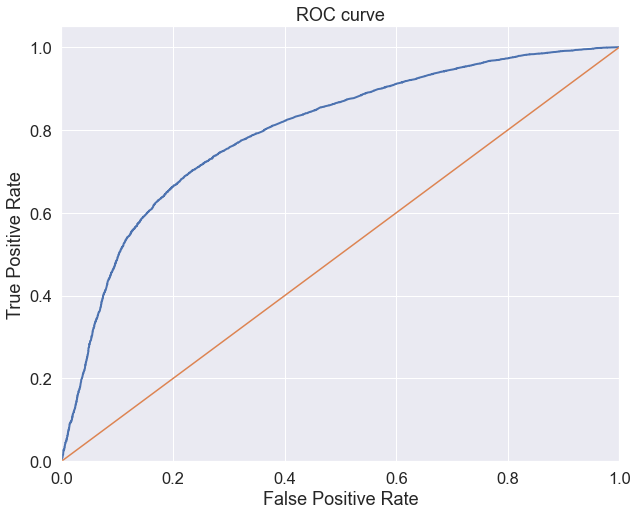

In [18]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [19]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7964637018401831
log loss score: 0.5507320527457711


Confusion matrix, without normalization
[[5488 3332]
 [1650 7030]]


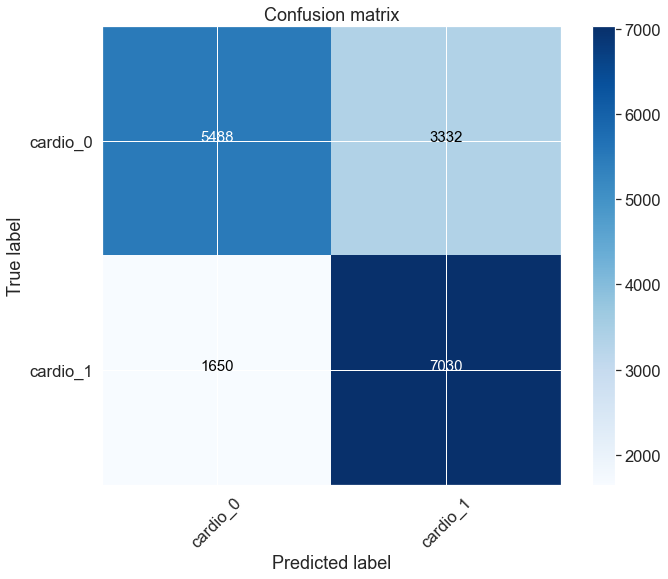

In [20]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [21]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8099078341013825, 0.37777777777777777, 0.6222222222222222)

Average precision-recall score: 0.77


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.77')

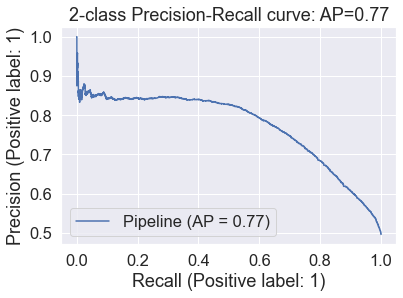

In [22]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [23]:
gbc_score = {"GradientBoostingClassifier":pd.Series([thresholds[ix],
                                             fscore[ix],
                                             precision[ix],
                                             recall[ix],
                                             roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]),
                                             log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1]),
                                             TPR,
                                             FPR,
                                             TNR],
                                            index=['Threshold',
                                                   'F-Score',
                                                   'Precision',
                                                   'Recall',
                                                   'ROC_AUC',
                                                   'LOG_LOSS',
                                                   'TPR',
                                                   'FPR',
                                                   'TNR'])}

df_score = df_score.join(pd.DataFrame(gbc_score))
df_score

,LogisticRegression,GradientBoostingClassifier
Threshold,0.386937,0.358156
F-Score,0.730323,0.738500
Precision,0.647431,0.678503
Recall,0.837558,0.810138
ROC_AUC,0.784035,0.796464
LOG_LOSS,0.577960,0.550732
TPR,0.837442,0.809908
FPR,0.448866,0.377778
TNR,0.551134,0.622222


#### AdaBoostClassifier

In [24]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7952419477681905+-0.0071441451920620375


In [25]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.497430, F-Score=0.738, Precision=0.692, Recall=0.789


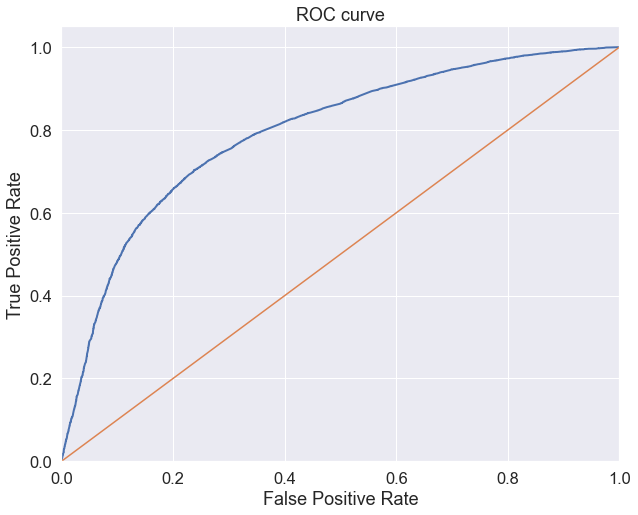

In [26]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [27]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7945722371129712
log loss score: 0.6869766413646277


Confusion matrix, without normalization
[[5777 3043]
 [1829 6851]]


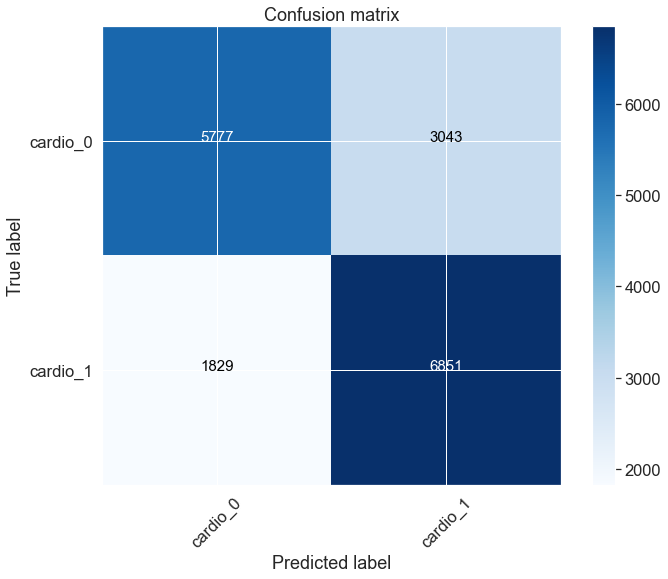

In [28]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [29]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7892857142857143, 0.3450113378684807, 0.6549886621315193)

Average precision-recall score: 0.77


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.77')

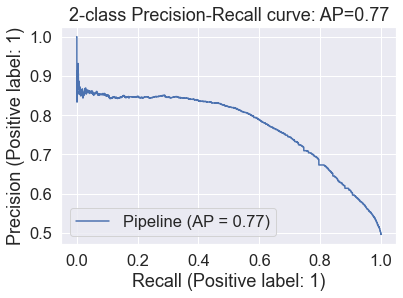

In [30]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [31]:
abc_score = {"AdaBoostClassifier": pd.Series([thresholds[ix],
                                              fscore[ix],
                                              precision[ix],
                                              recall[ix],
                                              roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]),
                                              log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1]),
                                              TPR,
                                              FPR,
                                              TNR],
                                             index=['Threshold',
                                                    'F-Score',
                                                    'Precision',
                                                    'Recall',
                                                    'ROC_AUC',
                                                    'LOG_LOSS',
                                                    'TPR',
                                                    'FPR',
                                                    'TNR'])}

df_score = df_score.join(pd.DataFrame(abc_score))
df_score

,LogisticRegression,GradientBoostingClassifier,AdaBoostClassifier
Threshold,0.386937,0.358156,0.497430
F-Score,0.730323,0.738500,0.737766
Precision,0.647431,0.678503,0.692471
Recall,0.837558,0.810138,0.789401
ROC_AUC,0.784035,0.796464,0.794572
LOG_LOSS,0.577960,0.550732,0.686977
TPR,0.837442,0.809908,0.789286
FPR,0.448866,0.377778,0.345011
TNR,0.551134,0.622222,0.654989


##### Случайный лес

In [32]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=2, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7849711151509939+-0.007123862605996867


In [33]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.434271, F-Score=0.734, Precision=0.668, Recall=0.814


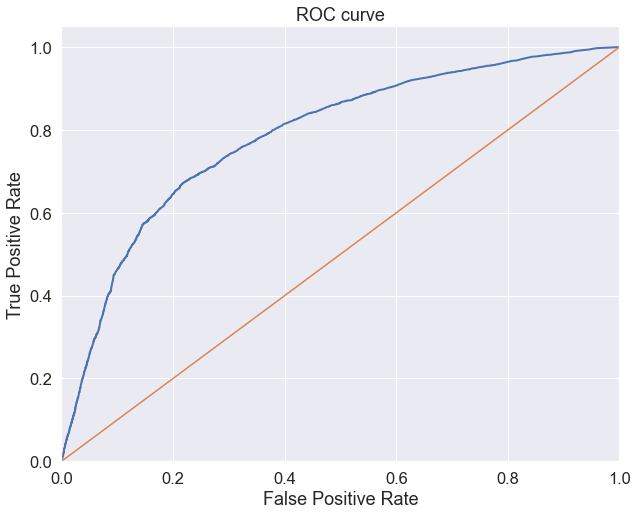

In [34]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [35]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7858433715267981
log loss score: 0.6000696954752374


Confusion matrix, without normalization
[[5332 3488]
 [1644 7036]]


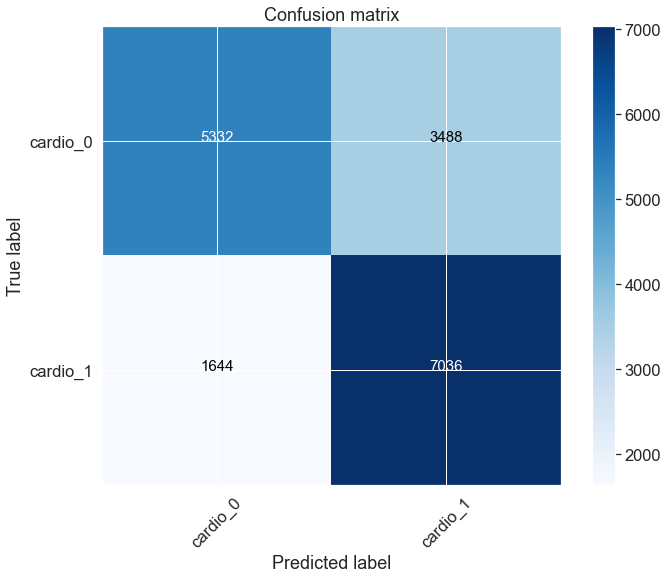

In [36]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8105990783410139, 0.39546485260770975, 0.6045351473922902)

Average precision-recall score: 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

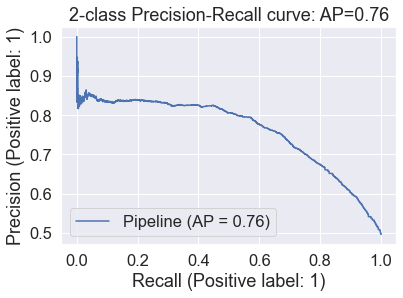

In [38]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [39]:
rfc_score = {"RandomForestClassifier": pd.Series([thresholds[ix],
                                                  fscore[ix],
                                                  precision[ix],
                                                  recall[ix],
                                                  roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]),
                                                  log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1]),
                                                  TPR,
                                                  FPR,
                                                  TNR],
                                                 index=['Threshold',
                                                        'F-Score',
                                                        'Precision',
                                                        'Recall',
                                                        'ROC_AUC',
                                                        'LOG_LOSS',
                                                        'TPR',
                                                        'FPR',
                                                        'TNR'])}

df_score = df_score.join(pd.DataFrame(rfc_score))
df_score

,LogisticRegression,GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
Threshold,0.386937,0.358156,0.497430,0.434271
F-Score,0.730323,0.738500,0.737766,0.733867
Precision,0.647431,0.678503,0.692471,0.668370
Recall,0.837558,0.810138,0.789401,0.813594
ROC_AUC,0.784035,0.796464,0.794572,0.785843
LOG_LOSS,0.577960,0.550732,0.686977,0.600070
TPR,0.837442,0.809908,0.789286,0.810599
FPR,0.448866,0.377778,0.345011,0.395465
TNR,0.551134,0.622222,0.654989,0.604535


#### 3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [40]:
df_score.T

,Threshold,F-Score,Precision,Recall,ROC_AUC,LOG_LOSS,TPR,FPR,TNR
LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,0.577960,0.837442,0.448866,0.551134
GradientBoostingClassifier,0.358156,0.738500,0.678503,0.810138,0.796464,0.550732,0.809908,0.377778,0.622222
AdaBoostClassifier,0.497430,0.737766,0.692471,0.789401,0.794572,0.686977,0.789286,0.345011,0.654989
RandomForestClassifier,0.434271,0.733867,0.668370,0.813594,0.785843,0.600070,0.810599,0.395465,0.604535


#### 4. Сделать выводы о том, какая модель справилась с задачей лучше других

По F-score результаты приблизительно равны, немного лучше других показал себя GradientBoostingClassifier. По Precision	- AdaBoostClassifier. По ROC_AUC лучше всего так же GradientBoostingClassifier.